# Predicting Age From X-Rays

# Goal
Develop an algorithm to determine the age of a child by utilizing x-rays of hands (pediatric hand radiographs).

## Expore the dataset

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

# CSV file contains the id, age, and gender related to each x-ray
dataset = pd.read_csv("Input/boneage-dataset.csv")
print('There are %d total data samples.' % dataset.shape[0])

# Age is in months, convert to years for convinence
dataset['boneage'] = dataset['boneage']/12.0
dataset.head()

There are 12611 total data samples.


,id,boneage,male
0,1377,15.000000,False
1,1378,1.000000,False
2,1379,7.833333,False
3,1380,10.000000,True
4,1381,6.833333,False


Mean and standard deviation of bone age is 10.61 and 3.43, respectively.
Total number of male and female is 6833 (54.18%) and 5778 (45.82%), respectively.


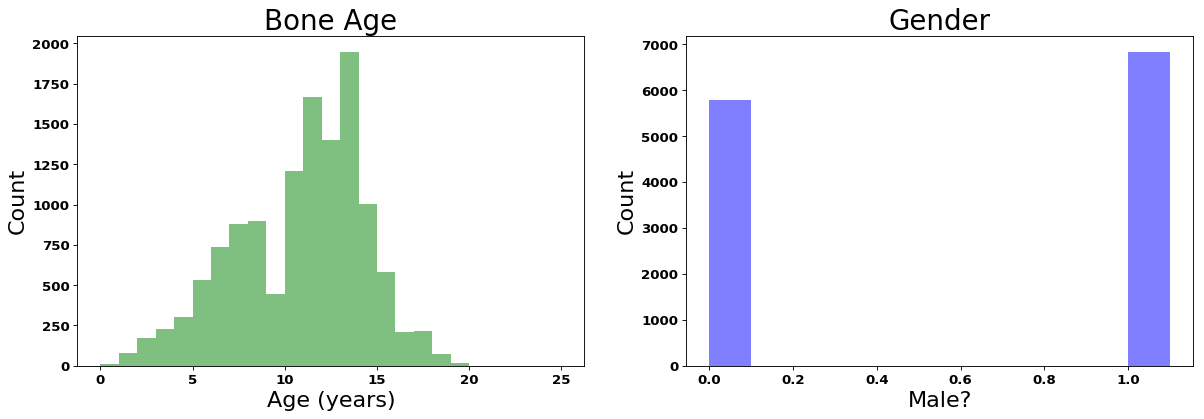

In [8]:
# Plot the total distribution for boneage and gender
import PlottingTools as pt

myFigure2 = plt.figure(figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k') 
myAxis1 = myFigure2.add_subplot(2,2,1)
myAxis2 = myFigure2.add_subplot(2,2,2)

myAxis1.hist(dataset['boneage'], 25, range = (0, 25.0), color='g', alpha=0.5)
myAxis2.hist(dataset['male'], 11, range = (0, 1.1), color='b', alpha=0.5)

#Title and stuff
pt.setTitle(myAxis1, 'Bone Age', 'Age (years)', 'Count')
pt.setTitle(myAxis2, 'Gender', 'Male?', 'Count')

#Ticks
pt.setTicks(myAxis1)
pt.setTicks(myAxis2)

print('Mean and standard deviation of bone age is %.2f and %.2f years, respectively.' %(dataset['boneage'].mean(), 
                                                              dataset['boneage'].std()))
print('Total number of male and female is %d (%.2f%%) and %d (%.2f%%), respectively.' 
      %(dataset[dataset['male']==1].shape[0], dataset[dataset['male']==1].shape[0]*100/dataset.shape[0],
        dataset[dataset['male']==0].shape[0], dataset[dataset['male']==0].shape[0]*100/dataset.shape[0]))

### Connect the x-ray images to the dataset

In [9]:
import os

dataset['image path'] = dataset['id'].map(lambda x: os.path.join('Input/boneage-dataset', '{}.png'.format(x)))

if dataset['image path'].map(os.path.exists).sum() != dataset.shape[0]:
    print('Warning!! Only', dataset['image path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total! \nWill continue with reduced dataset!!')
    dataset = dataset[dataset['image path'].map(os.path.exists)]
else:
    print(dataset['image path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total!')

Warning!! Only 5358 x-ray images found out of 12611 total! 
Will reduce the dataset!


### Preprocess the images for Keras

In [10]:
#The imagesToTensor function takes a numpy array of string-valued image paths 
#as input and returns a 4D tensor with shape

from keras.preprocessing import image                  
from tqdm import tqdm

def imageToTensor(image):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(image, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def imagesToTensor(images):
    listOfTensors = [imageToTensor(image) for image in tqdm(images)]
    return np.vstack(listOfTensors)

Using TensorFlow backend.


In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True          

# Convert every RGB x-ray images to 4D tensors
X = imagesToTensor(dataset['image path'])

# Rescale the images by dividing every pixel in every image by 255
# rescale [0,255] --> [0,1]
X = X.astype('float32')/255

# Set y
y = dataset['boneage']

100%|██████████| 5358/5358 [20:30<00:00,  5.68it/s]


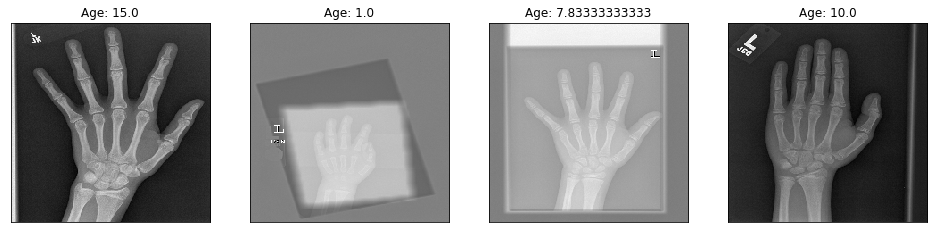

In [44]:
# Visualize the first four images

fig = plt.figure(figsize=(25,20))
for i in range(4):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X[i], cmap='gray')
    ax.set_title("Age: "+str(y[i]))

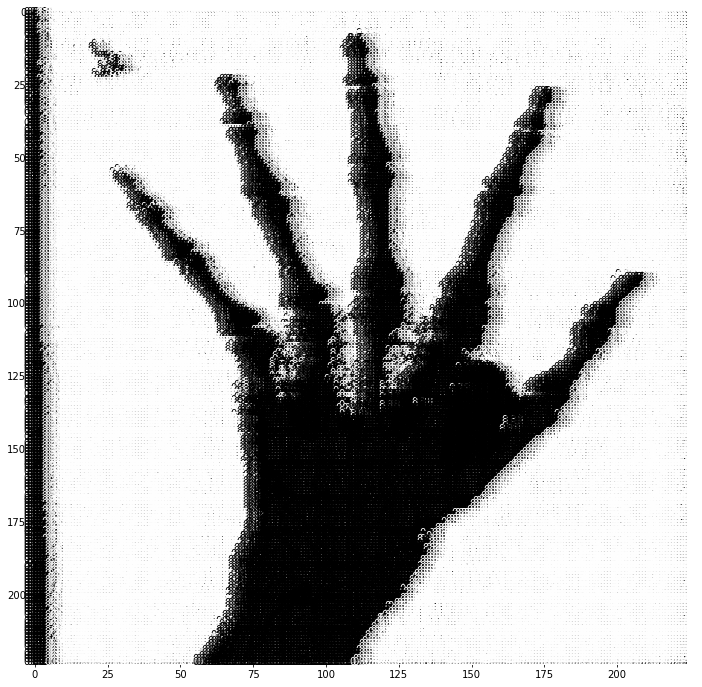

In [46]:
import cv2

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')



# convert to grayscale
gray_img = cv2.cvtColor(X[0], cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(gray_img, ax)

### Split data into training and testing sample

In [ ]:
from sklearn.model_selection import train_test_split

y = dataset['boneage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)

print("The dataset has a training set of %d examples." % len(X_train))
print("The dataset has a test set of %d examples." % len(X_test))